In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import io
from pytorch_lightning.callbacks import Callback
from datetime import datetime, date, time
from PIL import Image
import itertools 
from sklearn.model_selection import train_test_split
import torchvision.models as models

from Sources.callbacks_2classes_x10 import plot_confusion_matrix
from torch.nn import functional as F
from Sources.callbacks_2classes_x10 import get_true_classes
from Sources.callbacks_2classes_x10 import get_predicted_classes
from Sources.callbacks_2classes_x10 import get_classes_probs
from Sources.callbacks_2classes_x10 import callback
from Sources.callbacks_2classes_x10 import plot_to_image
from Sources.data_tools import ImageDataset_2cl
from Sources.ViT.models.modeling import VisionTransformer, CONFIGS

from Sources.vit_rollout import VITAttentionRollout
from Sources.pytorch_grad_cam_master.pytorch_grad_cam import GradCAM
from Sources.pytorch_grad_cam_master.pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm.notebook import tqdm_notebook

from fpdf import FPDF

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

labels_map = {
    0: "Benign",
    1: "Malignant",
}

transform_for_maps = transforms.Compose([
    transforms.Resize(256),
])

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = ImageDataset_2cl('../Data/burnasyan_Br.csv', 'val_paths_x10.txt', transform = transform_for_maps)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Using cuda device


In [3]:
# VIT
config = CONFIGS["ViT-B_16"]
vit = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=256, vis=True)
vit.head = nn.Linear(768, 1)
vit.load_state_dict(torch.load("../Logits/SavedNN/Saved_ViT_2cl_x10/" + str(8)))
vit.to(device)
vit.eval()

# RESNET
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(512, 1)
resnet.load_state_dict(torch.load("../Logits/SavedNN/Saved_ResNet18_2cl_x10/" + str(5)))
resnet.to(device)
resnet.eval()
None

In [20]:
# ORIGINAL
def get_original_image(input_tensor):
    return input_tensor[0].squeeze().permute(1, 2, 0).int()

# RESNET
def get_resnet_gradcam_map(input_tensor, cam, pred_label):
    
    target_category = pred_label
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    image = input_tensor.cpu().detach() / 255
    image = image.squeeze().permute(1, 2, 0).numpy()
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    
    return visualization

# VIT
def reshape_transform_func(tensor, height=16, width=16):
    result = tensor[:, :-1, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_vit_gradcam_map(input_tensor, cam, pred_label):

    target_category = pred_label
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
    
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    
    image = input_tensor.cpu().detach() / 255
    image = image.squeeze().permute(1, 2, 0).numpy()
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    
    return visualization
    
def get_vit_rollout_map(input_tensor, rollout, pred_label):

    mask = rollout(input_tensor)
    mask = mask / np.max(mask)
    
    image = input_tensor.cpu().detach() / 255
    image = image.squeeze().permute(1, 2, 0).numpy()
    mask = cv2.resize(mask, (256, 256))[..., np.newaxis]
    result = show_cam_on_image(image, mask, use_rgb=True)
    
    return result, mask.squeeze()

def ViTRollout_last_layer(input_tensor, rollout, pred_label):
    logits, att_mat = vit(input_tensor)
    att_mat = torch.stack(att_mat).squeeze(1)
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    
    mask = mask / np.max(mask)
    
    image = input_tensor.cpu().detach() / 255
    image = image.squeeze().permute(1, 2, 0).numpy()
    mask = cv2.resize(mask, (256, 256))[..., np.newaxis]
    result = show_cam_on_image(image, mask, use_rgb=False)
    
    return result
    

methods_dict = {
    "original": get_original_image,
    "resnet_gradcam": get_resnet_gradcam_map,
    "resnet_gradcam_aggr": get_resnet_gradcam_map,
    "vit_gradcam": get_vit_gradcam_map,
    "vit_gradcam_aggr": get_vit_gradcam_map,
    "vit_rollout": get_vit_rollout_map,
    "vit_rollout_last_layer": ViTRollout_last_layer,
}

In [17]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# CAM objects
# ResNet CAM
target_layers = [resnet.layer4[-1]]
resnet_cam = GradCAM(resnet, target_layers)

# ResNet CAM Aggregated
target_layers = [resnet.layer4[-1], resnet.layer3[-1], 
                 resnet.layer2[-1], resnet.layer1[-1]]
resnet_cam_aggr = GradCAM(resnet, target_layers)

# ViT CAM
target_layers = [vit.transformer.encoder.layer[-1]]
vit_cam = GradCAM(vit, target_layers, reshape_transform=reshape_transform_func)

# ViT CAM Aggregated
target_layers = [vit.transformer.encoder.layer[-1],
                 vit.transformer.encoder.layer[-2],
                 vit.transformer.encoder.layer[-3],
                 vit.transformer.encoder.layer[-4]]
vit_cam_aggr = GradCAM(vit, target_layers, reshape_transform=reshape_transform_func)
                       
# Rollout object
rollout = VITAttentionRollout(vit, discard_ratio=0.9, 
                              head_fusion='mean')

# ROLLOUT - MAX/MEAN ??

gettnig val maps:   0%|          | 0/3226 [00:00<?, ?it/s]

Feature batch shape: torch.Size([1, 3, 256, 256])
Labels batch shape: 1
torch.Size([256, 256, 3])


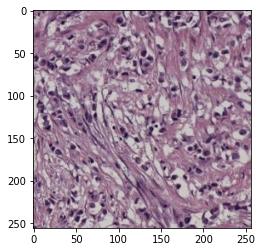

Label: 1


In [7]:
i = 0
for data in tqdm_notebook(val_dataloader, desc='gettnig val maps'):
    if i == 1:
        features, labels = data
        print(f"Feature batch shape: {features.size()}")
        print(f"Labels batch shape: {len(labels)}")
        img = features[0].squeeze().permute(1, 2, 0).int()
        print(img.shape)
        label = labels[0]
        plt.imshow(img)
        plt.show()
        print(f"Label: {label}")
        break
    i += 1

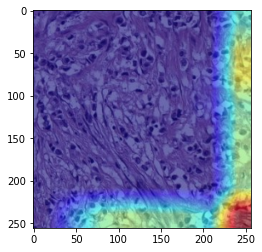

In [21]:
im = get_resnet_gradcam_map(features.to(device), resnet_cam, 1)
plt.imshow(im)

In [6]:
methods = [
           "original", 
           "resnet_gradcam",
           "vit_rollout"
          ]

## File generation

In [7]:
# functions
def get_plot_and_labels(data, methods):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs_for_networks = transform(inputs).to(device)
    inputs = inputs.to(device)
    
    real_label = labels[0].item()
#     real_label = labels_map[label]
    
    with torch.no_grad():
        
        vit_prob = vit(inputs_for_networks)[0]
        resnet_prob = resnet(inputs_for_networks)
            
    resnet_prob = torch.sigmoid(resnet_prob)
    resnet_prob = float(resnet_prob.cpu().detach())
    if resnet_prob >= 0.5:
        resnet_label = 1
    else:
        resnet_label = 0
        
    vit_prob = torch.sigmoid(vit_prob)
    vit_prob = float(vit_prob.cpu().detach())
    if vit_prob >= 0.5:
        vit_label = 1
    else:
        vit_label = 0
        
    
    if k_dict[labels_map[int(vit_label)]][labels_map[int(resnet_label)]] >= 50:
        return np.int32(0), 0, labels_map[int(resnet_label)], labels_map[int(vit_label)], 0
    
    for method_i, method in enumerate(methods):
        if method == "original":
            visualization = methods_dict[method](inputs.cpu())
#             print("orig")
        else:
            if method == "resnet_gradcam": 
                visualization, map1 = methods_dict[method](inputs, 
                                                     resnet_cam, 
                                                     resnet_label)
#                 print("resnet_gradcam")
            elif method == "resnet_gradcam_aggr":
                visualization = methods_dict[method](inputs, 
                                                     resnet_cam_aggr, 
                                                     resnet_label)
#                 print("resnet_gradcam_aggr")
            elif method == "vit_gradcam":
                visualization = methods_dict[method](inputs, 
                                                     vit_cam,
                                                     vit_label)
#                 print("vit_gradcam")
            elif method == "vit_gradcam_aggr":
                visualization = methods_dict[method](inputs, 
                                                     vit_cam_aggr,
                                                     vit_label)
#                 print("vit_gradcam_aggr")
            elif method == "vit_rollout":
                visualization, map2 = methods_dict[method](inputs, 
                                                     rollout,
                                                     vit_label)
#                 print("vit_rollout")
            else:
                visualization = methods_dict[method](inputs, 
                                                     rollout,
                                                     vit_label)
                
#         ax[method_i // 3 % 2][method_i % 3].get_xaxis().set_visible(False)
#         ax[method_i // 3 % 2][method_i % 3].get_yaxis().set_visible(False)
#         ax[method_i // 3 % 2][method_i % 3].set_title(method)
#         ax[method_i // 3 % 2][method_i % 3].imshow(visualization)
        
        ax[method_i].get_xaxis().set_visible(False)
        ax[method_i].get_yaxis().set_visible(False)
        ax[method_i].set_title(method)
        ax[method_i].imshow(visualization)
        
    del inputs_for_networks
    
    resnet_label = labels_map[int(resnet_label)]
    vit_label = labels_map[int(vit_label)]
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig("test.jpg", bbox_inches='tight', pad_inches=0)
    plt.cla()
    img_to_save = Image.open("test.jpg")
    img_to_save = img_to_save.convert("RGB")
    
    siou = siou_for_2_maps(map1, map2)
    
    del inputs
    torch.cuda.empty_cache()
    
    return img_to_save, real_label, resnet_label, vit_label, siou

def save_maps_to_folders(img_to_save, 
                                 real_label, vit_label, resnet_label, 
                                 k_dict, siou):
    # choose the folder
    if vit_label == "Benign":
        if resnet_label == "Benign":
            folder = "Maps_x10/ViT_Benign_ResNet_Benign"
        else:
            folder = "Maps_x10/ViT_Benign_ResNet_Malignant"
    else:
        if resnet_label == "Benign":
            folder = "Maps_x10/ViT_Malignant_ResNet_Benign"
        else:
            folder = "Maps_x10/ViT_Malignant_ResNet_Malignant"
    
#     folder = "Test_maps"
    
    # save img to folder
    if k_dict[vit_label][resnet_label] >= 50:
        return 1
    
    # resnet or vit
    img_path = os.path.join(folder,
                            np.str(k_dict[vit_label][resnet_label]) + 
                            '_' + str(real_label) + '.jpg')
    cv2.imwrite(img_path, cv2.cvtColor(np.array(img_to_save), cv2.COLOR_RGB2BGR))
            
    k_dict[vit_label][resnet_label] += 1
    
    real_label = labels_map[int(real_label)]
    
    dict_item = {
        'path': img_path,
        'real_label': real_label, 
        'vit_label': vit_label, 
        'resnet_label': resnet_label, 
        'sIoU': siou
    }
    
    rows.append(dict_item)
    
    return 0
    
def siou_for_2_maps(map1, map2):
    return 2 * np.sum(np.minimum(map1, map2)) / np.sum(np.add(map1, map2))

In [9]:
k_dict = {
    "Benign": {
        "Benign": 0,
        "Malignant": 0,
    },
    "Malignant": {
        "Benign": 0,
        "Malignant": 0,
    },
}

real_labels = {
    "Benign": {
        "Benign": [],
        "Malignant": [],
    },
    "Malignant": {
        "Benign": [],
        "Malignant": [],
    },
}

rows = []

plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
# fig, ax = plt.subplots(1, 6, figsize=(56, 8))
fig.tight_layout()

for data in tqdm_notebook(val_dataloader, desc='gettnig val maps'):
        
    img_to_save, real_label, resnet_label, vit_label, siou = get_plot_and_labels(data, methods)
        
#     if type(img_to_save) != np.int32:
#         real_labels[vit_label][resnet_label].append(real_label)
    
    flag = save_maps_to_folders(img_to_save, 
                                 real_label, vit_label, resnet_label, 
                                 k_dict, siou)
    
    if sum(k_dict["Benign"].values()) + sum(k_dict["Malignant"].values()) >= 200:
        break
            
plt.close(fig)

gettnig val maps:   0%|          | 0/3226 [00:00<?, ?it/s]

In [10]:
fieldnames = ['path', 'real_label', 'vit_label', 'resnet_label', 'sIoU']

with open('maps_info.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

In [2]:
data = pd.read_csv('maps_info.csv')

In [3]:
data.head(15)

,path,real_label,vit_label,resnet_label,sIoU
0,Maps_x10/ViT_Benign_ResNet_Benign/0_1.jpg,Malignant,Benign,Benign,0.234736
1,Maps_x10/ViT_Malignant_ResNet_Malignant/0_1.jpg,Malignant,Malignant,Malignant,0.228447
2,Maps_x10/ViT_Malignant_ResNet_Malignant/1_1.jpg,Malignant,Malignant,Malignant,0.290564
3,Maps_x10/ViT_Benign_ResNet_Benign/1_0.jpg,Benign,Benign,Benign,0.173620
4,Maps_x10/ViT_Benign_ResNet_Benign/2_0.jpg,Benign,Benign,Benign,0.189917
5,Maps_x10/ViT_Benign_ResNet_Malignant/0_1.jpg,Malignant,Benign,Malignant,0.091651
6,Maps_x10/ViT_Benign_ResNet_Malignant/1_1.jpg,Malignant,Benign,Malignant,0.179637
7,Maps_x10/ViT_Benign_ResNet_Benign/3_0.jpg,Benign,Benign,Benign,0.259724
8,Maps_x10/ViT_Malignant_ResNet_Malignant/2_1.jpg,Malignant,Malignant,Malignant,0.225463
9,Maps_x10/ViT_Malignant_ResNet_Malignant/3_1.jpg,Malignant,Malignant,Malignant,0.252422


In [4]:
print(data["sIoU"][data["path"] == 'Maps_x10/ViT_Malignant_ResNet_Malignant/36_1.jpg'])

63    0.209423
Name: sIoU, dtype: float64


In [4]:
data["sIoU"].mean()

0.21223024757812495

In [5]:
siou = pd.DataFrame(data.sIoU)
siou.head(15)

,sIoU
0,0.234736
1,0.228447
2,0.290564
3,0.173620
4,0.189917
5,0.091651
6,0.179637
7,0.259724
8,0.225463
9,0.252422


## PDFs

In [ ]:
def save_images_to_pdf(num, folder, pdf_name):
    
    # num - number of images in one folder
    # real_labels - array
    
    pdf = FPDF('L', 'mm', 'A4')
    pdf.set_font('Arial', 'B', 12)
    
    for i in range(num):
        img_path = os.path.join(folder, np.str(i) + '.jpg')
        pdf.add_page()
#         pdf.cell(300, 10, 'Real label: ' + real_labels[i], ln = 1)
        pdf.image(img_path, w = 240) # save to pdf
#         pdf.set_y(pdf.y + 40)
    
    pdf.output(pdf_name, "F")
    pdf.close()

In [8]:
num = 100

folders = ["Maps_2cl/ViT_Benign_ResNet_Benign",
           "Maps_2cl/ViT_Benign_ResNet_Malignant",
           "Maps_2cl/ViT_Malignant_ResNet_Benign",
           "Maps_2cl/ViT_Malignant_ResNet_Malignant"]
pdf_names = ["ViT_Benign_ResNet_Benign.pdf",
             "ViT_Benign_ResNet_Malignant.pdf",
             "ViT_Malignant_ResNet_Benign.pdf",
             "ViT_Malignant_ResNet_Malignant.pdf"]

save_images_to_pdf(num,
                   folders[0], pdf_names[0])
save_images_to_pdf(num,
                   folders[1], pdf_names[1])
save_images_to_pdf(num,
                   folders[2], pdf_names[2])
save_images_to_pdf(num,
                   folders[3], pdf_names[3])

In [11]:
# concat images
num = 20

def concat_images(num, folder):
    for i in range(num):
        resnet_img = os.path.join(folder, 'resnet' + np.str(i) + '.jpg')
        vit_img = os.path.join(folder, 'vit' + np.str(i) + '.jpg')
        img = Image.new('RGB', (224, 224*6))
        img1 = Image.open(resnet_img)
        img2 = Image.open(vit_img)
        img.paste(img1, (0,0))
        img.paste(img2, (0,224))
        img_path = os.path.join(folder, np.str(i) + '.jpg')
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


In [25]:
def write_plots_to_pdf(methods): 
    k_dict = {
        "Benign": {
            "Benign": 0,
            "Malignant": 0,
        },
        "Malignant": {
            "Benign": 0,
            "Malignant": 0,
        },
    }
    
    pdf_bb = FPDF('L', 'mm', 'A4')
    pdf_bm = FPDF('L', 'mm', 'A4')
    pdf_mb = FPDF('L', 'mm', 'A4')
    pdf_mm = FPDF('L', 'mm', 'A4')
    
    for data in tqdm_notebook(val_dataloader, desc='gettnig val maps'):
        
        img_to_save, real_label, resnet_label, vit_label = get_plot_and_labels(data, methods)
        
        flag = save_maps_to_folders_and_pdf(img_to_save, 
                                 real_label, vit_label, resnet_label, 
                                 k_dict, pdf_bb, pdf_bm, pdf_mb, pdf_mm)
            
    pdf_bb.output("ViT_Benign_ResNet_Benign.pdf", "F")
    pdf_bm.output("ViT_Benign_ResNet_Malignant.pdf", "F")
    pdf_mb.output("ViT_Malignant_ResNet_Benign.pdf", "F")
    pdf_mm.output("ViT_Malignant_ResNet_Malignant.pdf", "F")

In [ ]:
write_plots_to_pdf(methods)

gettnig val maps:   0%|          | 0/10510 [00:00<?, ?it/s]

### Without function

In [7]:
k_dict = {
        "Benign": {
            "Benign": 0,
            "Malignant": 0,
        },
        "Malignant": {
            "Benign": 0,
            "Malignant": 0,
        },
    }

print(k_dict["Benign"]["Benign"])

0


In [47]:
str = "Hello, gistology!"
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, str)
pdf.output('test.pdf', 'F')

''

In [48]:
plt.show()

In [16]:
def maps(methods, NUM):

    for data in tqdm_notebook(val_dataloader, desc='gettnig val maps'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
    
        # save img name + label
        label = labels[0].item()
        print("real_label: ", labels_map[label])
    
        fig, ax = plt.subplots(1, len(methods), figsize=(16, 16))

        for method_i, method in enumerate(methods):
            if method == "original":
                visualization = methods_dict[method](inputs)
            else:
                visualization, pred_label = methods_dict[method](inputs)
                print(method, "pred label: ", labels_map[int(pred_label)])
            ax[method_i].get_xaxis().set_visible(False)
            ax[method_i].get_yaxis().set_visible(False)
            ax[method_i].set_title(method)
            ax[method_i].imshow(visualization)
            
        plt.subplots_adjust(wspace=0, hspace=0)
        
        buf = io.BytesIO()
        plt.savefig(buf, format='jpg', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        img_to_save = Image.open(buf)
        img_to_save = img_to_save.convert("RGB")
        
        return(img_to_save)

In [17]:
fig_img = maps(methods, 1)

gettnig val maps:   0%|          | 0/10510 [00:00<?, ?it/s]

real_label:  Benign
resnet_gradcam pred label:  Malignant
resnet_gradcam_aggr pred label:  Malignant
vit_gradcam pred label:  Malignant
vit_gradcam_aggr pred label:  Malignant
vit_rollout pred label:  Malignant


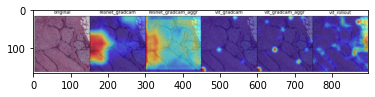

In [18]:
plt.imshow(fig_img)
plt.show()

In [19]:
print(fig_img.size)

(896, 168)


In [20]:

cv2.imwrite("Maps_2cl/ViT_Malignant_ResNet_Malignant/0.jpg", 
            cv2.cvtColor(np.array(fig_img), cv2.COLOR_RGB2BGR))

True

In [179]:
pdf = FPDF('L', 'mm', 'A4')
pdf.add_page()
# pdf.set_font('Arial', '', 13)
# pdf.cell(40, 10, "real_label", ln = 1)
# pdf.cell(40, 10, "real_label", ln = 1)
# pdf.cell(40, 10, "real_label", ln = 1)
pdf.image("onePic.jpg", w = 280)
# pdf.image("onePic2.jpg", x = 5, y = 100, w = 280)
pdf.output('test.pdf', 'F')

''

In [5]:
def maps_visualization(methods, NUM):
    
    k = 0
    
    for data in tqdm_notebook(val_dataloader, desc='gettnig val maps'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
    
        # save img name + label
        label = labels[0].item()
        print("real_label: ", labels_map[label])
    
        fig, ax = plt.subplots(1, len(methods), figsize=(16, 16))

        for method_i, method in enumerate(methods):
            if method == "original":
                visualization = methods_dict[method](inputs)
            else:
                visualization, pred_label = methods_dict[method](inputs)
                print(method, "pred label: ", labels_map[int(pred_label)])
            ax[method_i].get_xaxis().set_visible(False)
            ax[method_i].get_yaxis().set_visible(False)
            ax[method_i].set_title(method)
            ax[method_i].imshow(visualization.cpu())
            
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
            
        k += 1
            
        if k == NUM:
            break